
📊 Validation Results:

Decision Tree Validation Accuracy: 1.000
Decision Tree Validation ROC-AUC Score: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        16

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104


SVM Validation Accuracy: 0.846
SVM Validation ROC-AUC Score: 0.881
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        88
           1       0.50      0.50      0.50        16

    accuracy                           0.85       104
   macro avg       0.70      0.70      0.70       104
weighted avg       0.85      0.85      0.85       104


Bagging Validation Accuracy: 1.000
Bagging Validation ROC-AUC Score: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00   

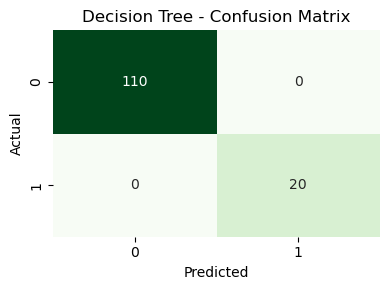


SVM Test Accuracy: 0.931
SVM Test ROC-AUC Score: 0.969
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       110
           1       0.87      0.65      0.74        20

    accuracy                           0.93       130
   macro avg       0.90      0.82      0.85       130
weighted avg       0.93      0.93      0.93       130



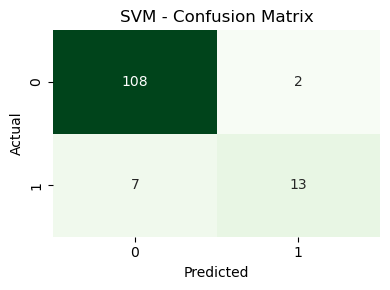


Bagging Test Accuracy: 1.000
Bagging Test ROC-AUC Score: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00        20

    accuracy                           1.00       130
   macro avg       1.00      1.00      1.00       130
weighted avg       1.00      1.00      1.00       130



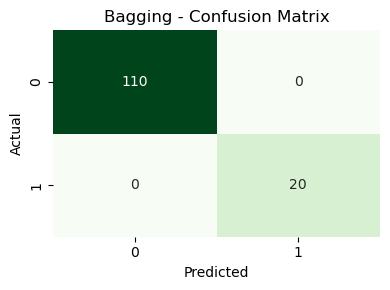


AdaBoost Test Accuracy: 1.000
AdaBoost Test ROC-AUC Score: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00        20

    accuracy                           1.00       130
   macro avg       1.00      1.00      1.00       130
weighted avg       1.00      1.00      1.00       130



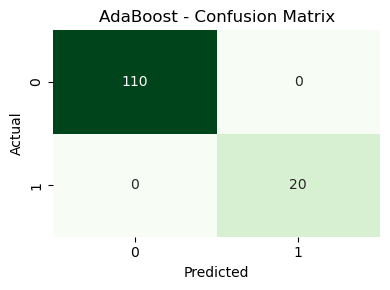


XGBoost Test Accuracy: 1.000
XGBoost Test ROC-AUC Score: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00        20

    accuracy                           1.00       130
   macro avg       1.00      1.00      1.00       130
weighted avg       1.00      1.00      1.00       130



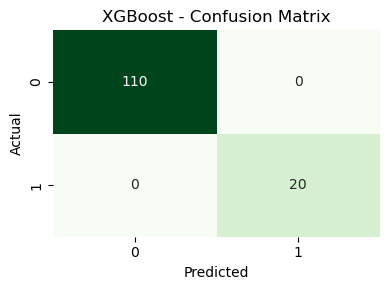

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# 1. Load CSV
df = pd.read_csv(r"C:\Users\hyazi\Downloads\archive (1)\student dropout.csv")

# 2. Encode categorical columns
cat_cols = ['School','Gender','Address','Family_Size','Parental_Status',
            'Mother_Job','Father_Job','Reason_for_Choosing_School',
            'Guardian','School_Support','Family_Support','Extra_Paid_Class',
            'Extra_Curricular_Activities','Attended_Nursery',
            'Wants_Higher_Education','Internet_Access','In_Relationship']

for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# 3. Separate features and target
X = df.drop(['student_id', 'Dropped_Out'], axis=1, errors='ignore')
y = df['Dropped_Out'].astype(int)

# 4. Split dataset BEFORE applying SMOTE (to avoid leakage)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# 5. Apply SMOTE ONLY to training set
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

# 6. Feature scaling
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 7. Define models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.8, algorithm='SAMME', random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=4, reg_alpha=0.1, reg_lambda=1,
                             eval_metric='logloss', learning_rate=0.1, random_state=42)
}

# 8. Training & Validation
print("\n📊 Validation Results:")
for name, model in models.items():
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    val_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None

    print(f"\n{name} Validation Accuracy: {accuracy_score(y_val, val_pred):.3f}")
    if val_proba is not None:
        print(f"{name} Validation ROC-AUC Score: {roc_auc_score(y_val, val_proba):.3f}")
    print(classification_report(y_val, val_pred))

# 9. Final Test Evaluation
print("\n🔍 Final Test Set Results:")
for name, model in models.items():
    test_pred = model.predict(X_test)
    test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    print(f"\n{name} Test Accuracy: {accuracy_score(y_test, test_pred):.3f}")
    if test_proba is not None:
        print(f"{name} Test ROC-AUC Score: {roc_auc_score(y_test, test_proba):.3f}")
    print(classification_report(y_test, test_pred))

    # Optional: Plot Confusion Matrix
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# 1. Load Data
df = pd.read_csv(r"C:\Users\hyazi\Downloads\archive (1)\student dropout.csv")

# 2. Encode Categorical Features
cat_cols = ['School','Gender','Address','Family_Size','Parental_Status',
            'Mother_Job','Father_Job','Reason_for_Choosing_School',
            'Guardian','School_Support','Family_Support','Extra_Paid_Class',
            'Extra_Curricular_Activities','Attended_Nursery',
            'Wants_Higher_Education','Internet_Access','In_Relationship']

for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# 3. Features and Target
X = df.drop(['student_id', 'Dropped_Out'], axis=1, errors='ignore')
y = df['Dropped_Out'].astype(int)

# 4. Balance the Dataset
X, y = SMOTE(random_state=42).fit_resample(X, y)

# 5. Train, Validation, Test Split (Stratified)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# 6. Feature Scaling
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 7. Model Initialization
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.8, algorithm='SAMME', random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=4, reg_alpha=0.1, reg_lambda=1,
                             eval_metric='logloss', learning_rate=0.1, random_state=42)
}

# 8. Training and Validation
print("\n📊 Validation Results:")
for name, model in models.items():
    if name == 'XGBoost':
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=10,
                  verbose=False)
    else:
        model.fit(X_train, y_train)

    val_pred = model.predict(X_val)
    val_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None

    print(f"\n{name} Validation Accuracy: {accuracy_score(y_val, val_pred):.3f}")
    if val_proba is not None:
        print(f"{name} Validation ROC-AUC Score: {roc_auc_score(y_val, val_proba):.3f}")
    print(classification_report(y_val, val_pred))

# 9. Final Testing
print("\n🔍 Final Test Set Results:")
for name, model in models.items():
    test_pred = model.predict(X_test)
    test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    print(f"\n{name} Test Accuracy: {accuracy_score(y_test, test_pred):.3f}")
    if test_proba is not None:
        print(f"{name} Test ROC-AUC Score: {roc_auc_score(y_test, test_proba):.3f}")
    print(classification_report(y_test, test_pred))



📊 Validation Results:

Decision Tree Validation Accuracy: 1.000
Decision Tree Validation ROC-AUC Score: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        88

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176


SVM Validation Accuracy: 0.966
SVM Validation ROC-AUC Score: 0.997
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        88
           1       0.97      0.97      0.97        88

    accuracy                           0.97       176
   macro avg       0.97      0.97      0.97       176
weighted avg       0.97      0.97      0.97       176


Bagging Validation Accuracy: 1.000
Bagging Validation ROC-AUC Score: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00   

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv(r"C:\Users\hyazi\Downloads\archive (1)\student dropout.csv")

# General overview
print(df.info())
print(df.describe())
print(df['Dropped_Out'].value_counts())

# Set plot theme
sns.set(style="whitegrid")

# 1. Class Distribution (Dropped Out vs Not)
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Dropped_Out', palette='pastel')
plt.title("Dropout Class Distribution")
plt.xlabel("Dropped Out (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# 2. Gender vs Dropout
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Gender', hue='Dropped_Out', palette='Set2')
plt.title("Dropout by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# 3. Family Size vs Dropout
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Family_Size', hue='Dropped_Out', palette='Set1')
plt.title("Dropout by Family Size")
plt.show()

# 4. Heatmap of Correlation
plt.figure(figsize=(12,10))
encoded_df = df.copy()
# Encode categorical columns for correlation heatmap
from sklearn.preprocessing import LabelEncoder
for col in encoded_df.select_dtypes(include='object').columns:
    encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col])

sns.heatmap(encoded_df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# 5. Boxplot of Final Grade vs Dropout
if 'G3' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x='Dropped_Out', y='G3', palette='Set3')
    plt.title("Final Grade vs Dropout")
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Let's say your full data is in X and y
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
from collections import Counter
print("After SMOTE:", Counter(y_train_smote))


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,     # prevents deprecation warning
    eval_metric='logloss',       # important for classification
    random_state=42
)


In [ ]:
import numpy as np

# Convert to NumPy arrays if not already
X_val_np = X_val.values if hasattr(X_val, 'values') else X_val
y_val_np = y_val.values if hasattr(y_val, 'values') else y_val



In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Fit using NumPy arrays to avoid TypeError
xgb_model.fit(
    X_train_smote,
    y_train_smote,
    eval_set=[(X_val_np, y_val_np)],
    early_stopping_rounds=10,
    verbose=True
)


NameError: name 'X_train_smote' is not defined

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Example with Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
scores = cross_val_score(dt, X, y, cv=skf, scoring='accuracy')
print("Decision Tree CV Accuracy: ", scores.mean())


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Split your data into training and validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create and train the model
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    early_stopping_rounds=10,
    verbose=True
)



In [ ]:
from xgboost import XGBClassifier
print(XGBClassifier.__module__)

In [ ]:
help(XGBClassifier.fit)


In [ ]:
print("5")

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Dummy dataset
X, y = make_classification(n_samples=500, n_features=10, random_state=42)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=True
)



In [ ]:
!pip uninstall xgboost -y



Found existing installation: xgboost 3.0.2
Uninstalling xgboost-3.0.2:
  Successfully uninstalled xgboost-3.0.2


You can safely remove it manually.
